In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image  # Import the Image module


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths
train_csv_path = '/content/drive/MyDrive/eyePACS/trainLabels.csv'
train_image_path = '/content/drive/MyDrive/eyePACS/train'
test_image_path = '/content/drive/MyDrive/eyePACS/test'
checkpoint_dir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create checkpoint directory if it does not exist
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pth')
save_path = '/content/drive/MyDrive/preprocessed_batches'
os.makedirs(save_path, exist_ok=True)  # Create save directory if it does not exist


In [ ]:
def plot_class_distribution(labels):
    class_counts = labels.value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette='viridis', legend=False)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Dataset')
    plt.show()


In [ ]:
# Bengraham Preprocessing
def bengraham_preprocessing(img):
    try:
        b, g, r = cv2.split(img)
        equalized_b = cv2.equalizeHist(b)
        equalized_g = cv2.equalizeHist(g)
        equalized_r = cv2.equalizeHist(r)
        equalized_img = cv2.merge((equalized_b, equalized_g, equalized_r))
        return equalized_img
    except Exception as e:
        print(f"Error in Bengraham preprocessing: {e}")
        return None

# Gaussian Blur with addWeighted
def gaussian_blur(img, kernel_size=(5, 5), alpha=1.5, beta=-0.5, gamma=0):
    try:
        blurred_img = cv2.GaussianBlur(img, kernel_size, 0)
        return cv2.addWeighted(img, alpha, blurred_img, beta, gamma)
    except Exception as e:
        print(f"Error in Gaussian blur: {e}")
        return None

# Circular Crop
def circular_crop(img):
    try:
        height, width = img.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(mask, (width//2, height//2), min(width//2, height//2), (255), -1)
        return cv2.bitwise_and(img, img, mask=mask)
    except Exception as e:
        print(f"Error in circular crop: {e}")
        return None

# Image Preprocessing Pipeline
def preprocess_image(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)  # Convert to numpy array

        # Apply Bengraham preprocessing
        img = bengraham_preprocessing(img)
        if img is None:
            return None

        # Apply Gaussian blur with addWeighted
        img = gaussian_blur(img)
        if img is None:
            return None

        # Apply circular cropping
        img = circular_crop(img)
        if img is None:
            return None

        # Resize to 224x224
        img_resized = cv2.resize(img, (224, 224))

        # Normalize the image to [0, 1]
        img_normalized = img_resized.astype(np.float32) / 255.0

        # Convert to uint8 for PIL
        img_uint8 = (img_normalized * 255).astype(np.uint8)

        return img_uint8

    except Exception as e:
        print(f"Error during preprocessing {img_path}: {e}")
        return None

In [ ]:
def display_samples_per_class(image_paths, labels, class_names, num_samples_per_class=5):
    class_samples = {class_name: [] for class_name in class_names}

    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        if len(class_samples[class_name]) < num_samples_per_class:
            preprocessed_img = preprocess_image(img_path)
            if preprocessed_img is not None:
                class_samples[class_name].append(preprocessed_img)

    num_classes = len(class_names)
    plt.figure(figsize=(15, num_classes * 3))

    for i, (class_name, samples) in enumerate(class_samples.items()):
        for j, img in enumerate(samples):
            plt.subplot(num_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(img)
            if j == 0:
                plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
# Load and Preprocess Data
labels = pd.read_csv(train_csv_path)
image_paths = [os.path.join(train_image_path, img + '.jpeg') for img in labels['image'].values]


# Encode Labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels['level'])

# Get class names from label encoder
class_names = le.classes_


In [ ]:
# Display sample images for each class
display_samples_per_class(image_paths, encoded_labels, class_names)

Output hidden; open in https://colab.research.google.com to view.

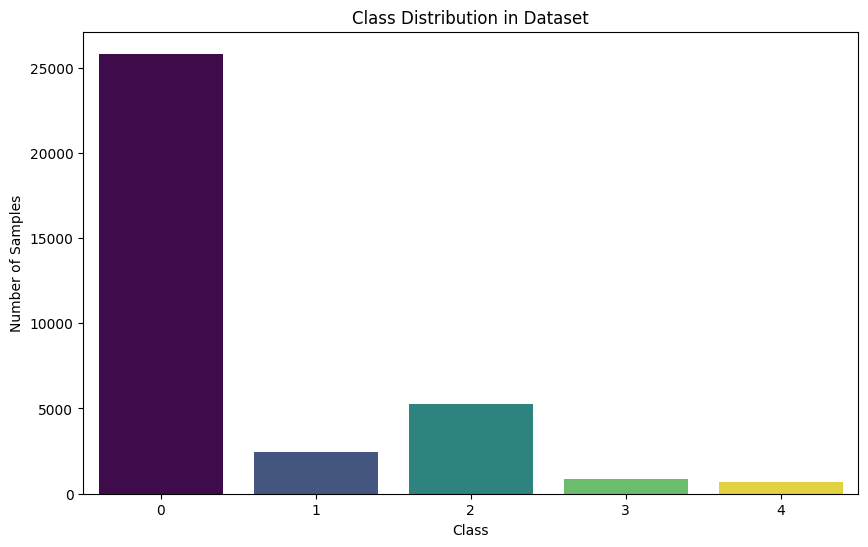

In [ ]:
# Plot class distribution before oversampling
plot_class_distribution(pd.Series(encoded_labels))

In [ ]:
# Get the count of each class in the dataset
class_counts = pd.Series(encoded_labels).value_counts()

# Map the counts to the class names
class_counts.index = le.inverse_transform(class_counts.index)

# Print the count of each class
print("Dataset count per class:")
print(class_counts)

Dataset count per class:
0    25810
2     5292
1     2443
3      873
4      708
Name: count, dtype: int64


In [ ]:
# Preprocess and save data
def preprocess_and_save_all_images(image_paths, labels, save_path):
    X, y = [], []
    for i, img_path in enumerate(image_paths):
        label = labels[i]
        preprocessed_img = preprocess_image(img_path)
        if preprocessed_img is not None:
            X.append(preprocessed_img)
            y.append(label)
        else:
            print(f"Skipping image {img_path} due to preprocessing error.")

    X_array = np.array(X)
    y_array = np.array(y)
    np.save(os.path.join(save_path, 'X_all.npy'), X_array)
    np.save(os.path.join(save_path, 'y_all.npy'), y_array)
    print(f"Saved all preprocessed data to {save_path}")

preprocess_and_save_all_images(image_paths, encoded_labels, save_path)


Saved all preprocessed data to /content/drive/MyDrive/preprocessed_batches


In [ ]:

# Paths to the saved preprocessed data
save_path = '/content/drive/MyDrive/preprocessed_batches'
X_file = os.path.join(save_path, 'X_all.npy')
y_file = os.path.join(save_path, 'y_all.npy')


In [ ]:
# Load the preprocessed data
X_all = np.load(X_file)
y_all = np.load(y_file)

print(f"Loaded data shapes: X_all - {X_all.shape}, y_all - {y_all.shape}")

Loaded data shapes: X_all - (35126, 224, 224, 3), y_all - (35126,)


In [ ]:
# Reshape if needed
if X_all.ndim == 3:
    X_all = X_all.reshape(-1, 224, 224, 3)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

# Save split data to disk
split_save_path = '/content/drive/MyDrive/train_val_split'
os.makedirs(split_save_path, exist_ok=True)
np.save(os.path.join(split_save_path, 'X_train.npy'), X_train)
np.save(os.path.join(split_save_path, 'y_train.npy'), y_train)
np.save(os.path.join(split_save_path, 'X_val.npy'), X_val)
np.save(os.path.join(split_save_path, 'y_val.npy'), y_val)

print("Train and validation split data saved.")

Train and validation split data saved.


In [ ]:
# Determine the number of samples
num_samples = X_train.shape[0]
print(f"Number of samples in X_train: {num_samples}")

Number of samples in X_train: 28100


In [ ]:
# Load training data from disk
split_save_path = '/content/drive/MyDrive/train_val_split'
X_train = np.load(os.path.join(split_save_path, 'X_train.npy'))
y_train = np.load(os.path.join(split_save_path, 'y_train.npy'))

print(f"Loaded training data shapes: X_train - {X_train.shape}, y_train - {y_train.shape}")

Loaded training data shapes: X_train - (28100, 224, 224, 3), y_train - (28100,)


In [ ]:
# Initialize SMOTE with k_neighbors
batch_size = 1000  # Example batch size
n_neighbors = 10   # Example k_neighbors value
sm = SMOTE(random_state=42, k_neighbors=n_neighbors)

# Save the resampled data in batches
resampled_save_path = '/content/drive/MyDrive/smote_resampled_batches'
os.makedirs(resampled_save_path, exist_ok=True)

# Batchwise processing
num_batches = (X_train.shape[0] + batch_size - 1) // batch_size
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, X_train.shape[0])

    X_batch = X_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]

    if len(X_batch) <= n_neighbors:
        print(f"Skipping batch {batch_idx} due to insufficient samples.")
        continue

    # Flatten images for SMOTE
    X_batch_flattened = X_batch.reshape(X_batch.shape[0], -1)

    # Apply SMOTE
    try:
        X_batch_res_flattened, y_batch_res = sm.fit_resample(X_batch_flattened, y_batch)
    except ValueError as e:
        print(f"Error applying SMOTE to batch {batch_idx}: {e}")
        continue

    # Reshape the oversampled data back to original image shape
    X_batch_res = X_batch_res_flattened.reshape(-1, 224, 224, 3)

    # Save the oversampled batch to disk
    np.save(os.path.join(resampled_save_path, f'X_train_res_batch_{batch_idx}.npy'), X_batch_res)
    np.save(os.path.join(resampled_save_path, f'y_train_res_batch_{batch_idx}.npy'), y_batch_res)

    print(f"Processed and saved batch {batch_idx}")

print("SMOTE applied batchwise and data saved.")

Processed and saved batch 0
Processed and saved batch 1
Processed and saved batch 2
Processed and saved batch 3
Processed and saved batch 4
Processed and saved batch 5
Processed and saved batch 6
Processed and saved batch 7
Processed and saved batch 8
Processed and saved batch 9
Processed and saved batch 10
Processed and saved batch 11
Processed and saved batch 12
Processed and saved batch 13
Processed and saved batch 14
Processed and saved batch 15
Processed and saved batch 16
Processed and saved batch 17
Processed and saved batch 18
Processed and saved batch 19
Processed and saved batch 20
Processed and saved batch 21
Processed and saved batch 22
Processed and saved batch 23
Processed and saved batch 24
Processed and saved batch 25
Processed and saved batch 26
Processed and saved batch 27
Error applying SMOTE to batch 28: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 11
SMOTE applied batchwise and data saved.


In [ ]:
y_train_res = np.load('/content/drive/MyDrive/smote_resampled_batches/y_train_res_batch_0.npy')

Class Distribution after SMOTE:
Class 0: 727 samples
Class 1: 727 samples
Class 2: 727 samples
Class 3: 727 samples
Class 4: 727 samples


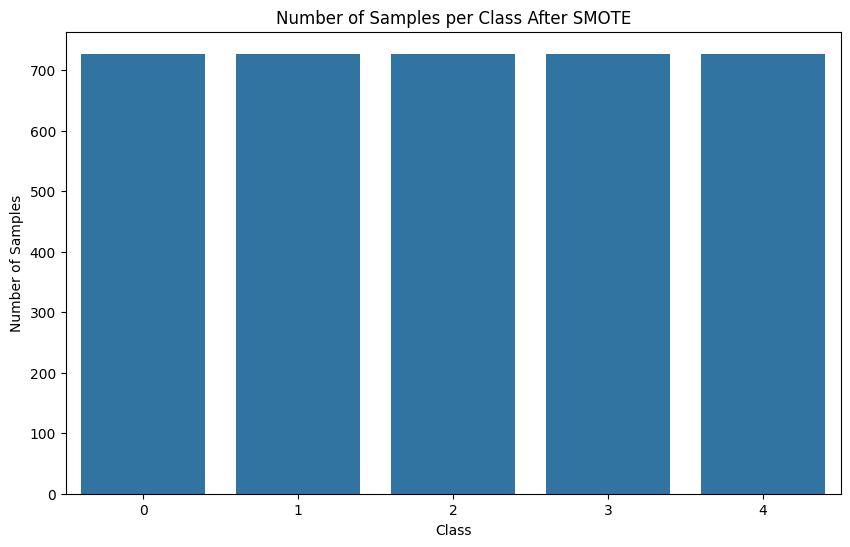

In [ ]:
# Plot class distribution
unique_classes, counts = np.unique(y_train_res, return_counts=True)
class_distribution = dict(zip(unique_classes, counts))

# Print the class distribution
print("Class Distribution after SMOTE:")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class After SMOTE')
plt.xticks(ticks=list(class_distribution.keys()))  # Ensure all class labels are displayed
plt.show()

In [ ]:
import os
print("Number of CPU cores:", os.cpu_count())


Number of CPU cores: 12


In [ ]:
from torchvision import transforms

In [ ]:
# Paths for SMOTE resampled batches and validation data
smote_resampled_batches_path = '/content/drive/MyDrive/smote_resampled_batches'
split_save_path = '/content/drive/MyDrive/train_val_split'

# Load validation data
X_val = np.load(os.path.join(split_save_path, 'X_val.npy'))
y_val = np.load(os.path.join(split_save_path, 'y_val.npy'))

# Load the SMOTE resampled data
train_images = []
train_labels = []

# Load each batch of the SMOTE-resampled data
for batch_idx in range(len(os.listdir(smote_resampled_batches_path)) // 2):  # assuming equal number of X and y files
    X_batch = np.load(os.path.join(smote_resampled_batches_path, f'X_train_res_batch_{batch_idx}.npy'))
    y_batch = np.load(os.path.join(smote_resampled_batches_path, f'y_train_res_batch_{batch_idx}.npy'))

    train_images.append(X_batch)
    train_labels.append(y_batch)

# Concatenate all batches
X_train = np.concatenate(train_images, axis=0)
y_train = np.concatenate(train_labels, axis=0)

print(f"Loaded SMOTE-processed training data shapes: X_train - {X_train.shape}, y_train - {y_train.shape}")


Loaded SMOTE-processed training data shapes: X_train - (102865, 224, 224, 3), y_train - (102865,)


In [ ]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray((image * 255).astype(np.uint8))  # Convert back to uint8 for PIL

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
batch_size=32

In [ ]:
# Create datasets
train_dataset = CustomDataset(images=X_train, labels=y_train, transform=train_transforms)
val_dataset = CustomDataset(images=X_val, labels=y_val, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(np.unique(y_train)) )



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)


In [ ]:
# Training loop with early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15,delta = 1e-4,verbose=False):
        self.patience = patience
        self.delta=delta
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.Inf

    def __call__(self, val_loss, model, epoch, optimizer, checkpoint_path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch, checkpoint_path)
        elif score < self.best_score - self.delta:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch, checkpoint_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model, optimizer, epoch, checkpoint_path):
        if self.verbose:
            print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...")
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }
        torch.save(checkpoint, checkpoint_path)
        self.best_loss = val_loss

In [ ]:
# Ensure checkpoint path exists
checkpoint_path = '/content/drive/MyDrive/checkpoint_ViT.pt'
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize early stopping
early_stopping = EarlyStopping(patience=15,delta=1e-4, verbose=True)


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
checkpoint_path = '/content/drive/MyDrive/checkpoint_ViT.pt'

# Check if checkpoint exists
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    vit_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("No checkpoint found, starting from scratch.")
    start_epoch = 0


No checkpoint found, starting from scratch.


In [ ]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    vit_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}')

    # Validation Phase
    vit_model.eval()
    val_running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vit_model(images).logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Check for early stopping
    early_stopping(epoch_val_loss, vit_model, epoch + 1, optimizer, checkpoint_path)

    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

print("Training completed.")

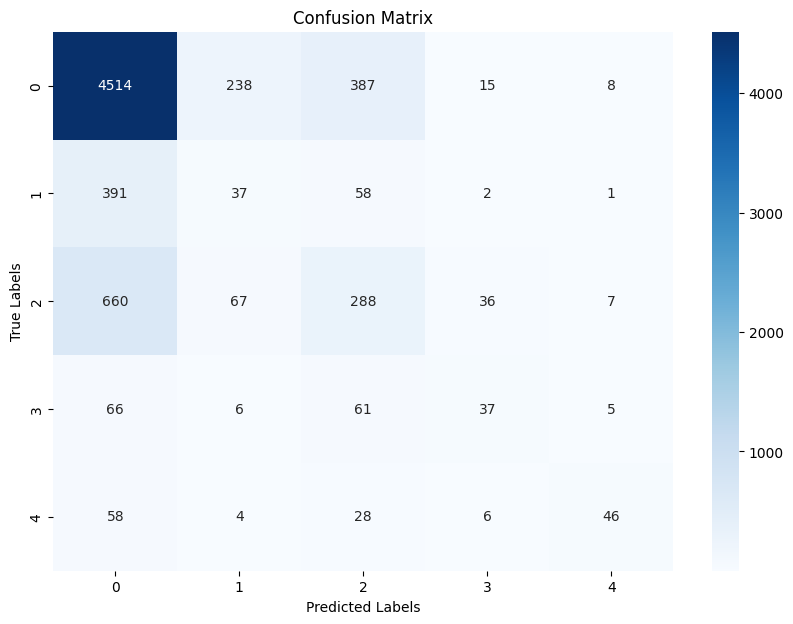

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5162
           1       0.11      0.08      0.09       489
           2       0.35      0.27      0.31      1058
           3       0.39      0.21      0.27       175
           4       0.69      0.32      0.44       142

    accuracy                           0.70      7026
   macro avg       0.46      0.35      0.39      7026
weighted avg       0.67      0.70      0.68      7026



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Evaluate the model on the validation set
y_val_true, y_val_pred = evaluate_model(vit_model, val_loader)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred, labels=np.arange(len(le.classes_)))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute classification report
class_names = [str(label) for label in le.classes_]
report = classification_report(y_val_true, y_val_pred, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)
